In [1]:
from music21 import *
import numpy as np
import time
# import edit_distance # pip install edit_distance for this to work
from typing import List, FrozenSet

c = converter.parse('mozart.mxl')

threshold = 0.5

In [2]:
def pitch_order(pitch_name: str):
    return pitch.Pitch(pitch_name).midi % 12

def remove_accidental(n: note.Note):
    n = note.Note(n.name)
    n.pitch.accidental = None
    return pitch_order(n.name)

In [3]:
def get_lev_distance(s, t):
    """ 
        iterative_levenshtein(s, t) -> ldist
        ldist is the Levenshtein distance between the strings 
        s and t.
        For all i and j, dist[i,j] will contain the Levenshtein 
        distance between the first i characters of s and the 
        first j characters of t
    """

    rows = len(s)+1
    cols = len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for i in range(1, rows):
        dist[i][0] = i

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0
            else:
                # Jaccard distance
                union_size = len(s[row-1] | t[col-1])
                intersection_size = len(s[row-1] & t[col-1])
                cost = 1 - intersection_size / union_size
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution
 
    return dist[-1][-1]

In [4]:
def get_lev_distance_ratio(list1, list2):
    if len(list1) == 0 and len(list2) == 0:
        return 0
    return get_lev_distance(list1, list2) / max(len(list1), len(list2))

In [5]:
def get_notes(part):
    notes = []
    for ch in part.recurse().getElementsByClass([note.Note, chord.Chord]):
        if isinstance(ch, chord.Chord):
            notes.append(frozenset({n.pitch.midi % 12 for n in ch.notes}))
        else:
            notes.append(frozenset({ch.pitch.midi % 12}))
    return notes

def inc_ledger_notes(note_set_list: List[FrozenSet[int]], delta: int):
    # delta is how much the note is transposed by according to ledger lines
    res = []
    for st in note_set_list:
        new_st = set()
        for x in st:
            p = pitch.Pitch(x)
            p.accidental = None
            mod7 = (ord(p.name) - ord('A') + delta) % 7
            new_pitch_name = chr(ord('A') + mod7)
            new_midi = pitch.Pitch(new_pitch_name).midi % 12
            new_st.add(new_midi)
            
        res.append(frozenset(new_st))
        
    return res

In [6]:
def inc_transpose_set(note_set_list: List[FrozenSet[int]], delta: int):
    res = []
    for st in note_set_list:
        res.append(frozenset({(x + delta) % 12 for x in st}))
    return res

In [7]:
def lcs_length(a, b):
    table = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    for i, ca in enumerate(a, 1):
        for j, cb in enumerate(b, 1):
            table[i][j] = (
                table[i - 1][j - 1] + 1 if ca == cb else
                max(table[i][j - 1], table[i - 1][j]))
    return table[-1][-1]

def get_lcs_ratio(a, b):
    if len(a) == 0 or len(b) == 0:
        return 0
    return lcs_length(a, b) / min(len(a), len(b))

In [8]:
def get_lev_distance_similarity(set_list1: List[FrozenSet[int]], set_list2: List[FrozenSet[int]]):
    return 1 - get_lev_distance_ratio(set_list1, set_list2)

def get_lcs_similarity(set_list1: List[FrozenSet[int]], set_list2: List[FrozenSet[int]]):
    return get_lcs_ratio(set_list1, set_list2)

def get_full_similarity(set_list1: List[FrozenSet[int]], set_list2: List[FrozenSet[int]]):
    return max(get_lev_distance_similarity(set_list1, set_list2),
              get_lcs_similarity(set_list1, set_list2))

In [9]:
def get_pitch_similarity(set_list1: List[FrozenSet[int]], set_list2: List[FrozenSet[int]], similarity_functions: List):
    """ Gets similarity between two rows of notes, denoted as lists of frozen-sets. 
        The pitches need to match. (but not necessarily the octaves) """
    sim = 0
    for sim_func in similarity_functions:
        sim = max(sim, sim_func(set_list1, set_list2))
    return sim

In [10]:
def get_ledger_similarity(set_list1: List[FrozenSet[int]], set_list2: List[FrozenSet[int]], similarity_functions: List):
    """ Gets similarity between two rows of notes, denoted as lists of frozen-sets. 
        Difference here is that you can transpose one of the sets BUT WE ONLY LOOK AT LEDGER LINES. """
    sim = 0
    set_list1 = inc_ledger_notes(set_list1, 0)
    for delta in range(7):
        notes2 = inc_ledger_notes(set_list2, delta)
        for sim_func in similarity_functions:
            sim = max(sim, sim_func(set_list1, notes2))
    return sim

In [11]:
def get_transpose_similarity(set_list1: List[FrozenSet[int]], set_list2: List[FrozenSet[int]], similarity_functions: List):
    """ Gets similarity between two rows of notes, denoted as lists of frozen-sets. 
        Difference here is that you can transpose one of the sets. We look at tones here"""
    sim = 0
    for delta in range(12):
        notes2 = inc_transpose_set(set_list2, delta)
        for sim_func in similarity_functions:
            sim = max(sim, sim_func(set_list1, notes2))
    return sim

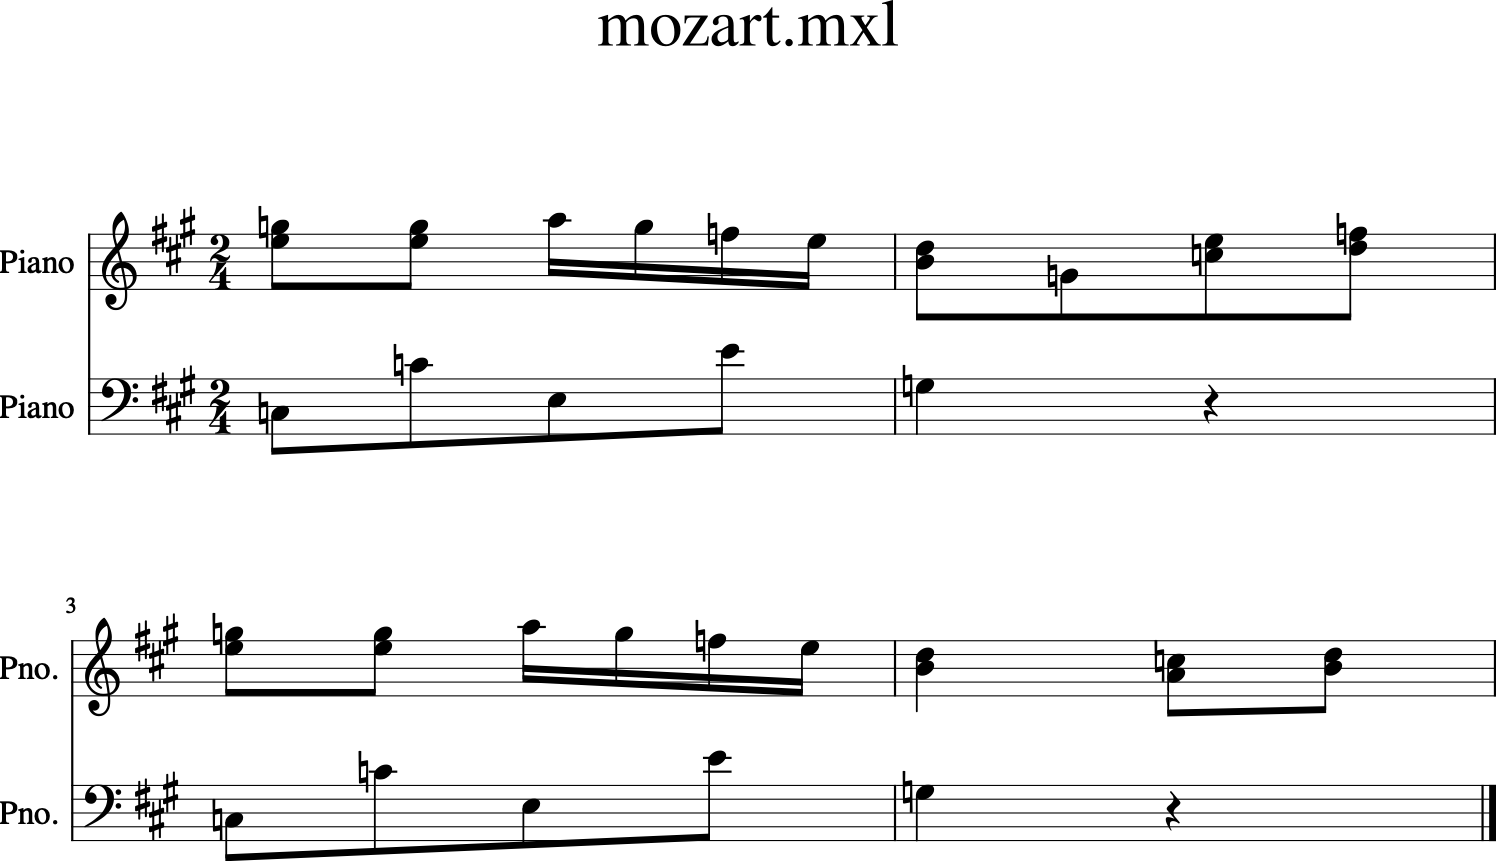

In [12]:
c.measures(10, 13).show()

In [13]:
c_measures = list(c.parts[0].getElementsByClass(stream.Measure))

In [14]:
print(len(list(c_measures)))

128


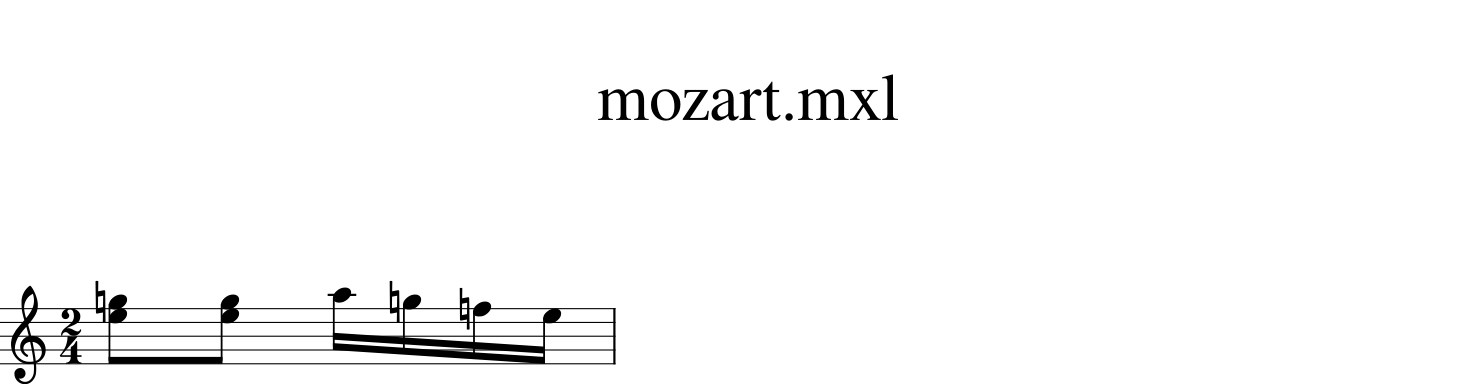

In [15]:
c_measures[11].show()

In [16]:
def get_similarity_matrix(measures: List[stream.Measure], similarity_type_function, similarity_algorithm_functions):
    # similarity type function: what TYPE of similarity? pitch, ledger, transpose?
    # similarity_algorithm_functions: what algos to use? lev distance, LCS?
    measures = list(measures)
    num_measures = len(measures)
    
    sim = np.zeros((len(measures), len(measures)))
    
    for i in range(len(measures)):
        notesi = get_notes(measures[i])
        sim[i][i] = 1
        for j in range(i + 1, len(measures)):
            notesj = get_notes(measures[j])
            try:
                sim[i][j] = sim[j][i] = similarity_type_function(notesi, notesj,
                                                     similarity_algorithm_functions)
            except ZeroDivisionError:
                measures[i].show()
                measures[j].show()
                raise ZeroDivisionError(f'Measure {i}, {j} got ZeroDivisionError')
    return sim

In [ ]:
def get_similarity_matrix2(measures1: List[stream.Measure], measures2: List[stream.Measure], similarity_type_function, similarity_algorithm_functions):
    # similarity matrix among two DIFFERENT sets of measures
    
    sim = np.zeros((len(measures1), len(measures2)))
    
    for i in range(len(measures1)):
        notesi = get_notes(measures1[i])
        for j in range(0, len(measures2)):
            notesj = get_notes(measures[j])
            try:
                sim[i][j] = sim[j][i] = similarity_type_function(notesi, notesj,
                                                     similarity_algorithm_functions)
            except ZeroDivisionError:
                measures[i].show()
                measures[j].show()
                raise ZeroDivisionError(f'Measure {i}, {j} got ZeroDivisionError')
    return sim

In [17]:
def get_both_parts_similarity_matrix(sc: stream.Score, similarity_type_function, similarity_algorithm_functions):
    # similarity type function: what TYPE of similarity? pitch, ledger, transpose?
    # similarity_algorithm_functions: what algos to use? lev distance, LCS?
    rh_weight = 0.85
    lh_weight = 1 - rh_weight
    
    rh_measures = list(sc.parts[0].getElementsByClass(stream.Measure))
    lh_measures = list(sc.parts[1].getElementsByClass(stream.Measure))
    
    rh_sim = get_similarity_matrix(
        rh_measures, similarity_type_function, similarity_algorithm_functions)
    
    lh_sim = get_similarity_matrix(
        lh_measures, similarity_type_function, similarity_algorithm_functions)
    
    lh_rh_sim = get_similarity_matrix(
        lh_measures, rh_measures, similarity_type_function, similarity_algorithm_functions)
    
    return np.max(rh_weight * rh_sim + lh_weight * lh_sim, lh_rh_sim)

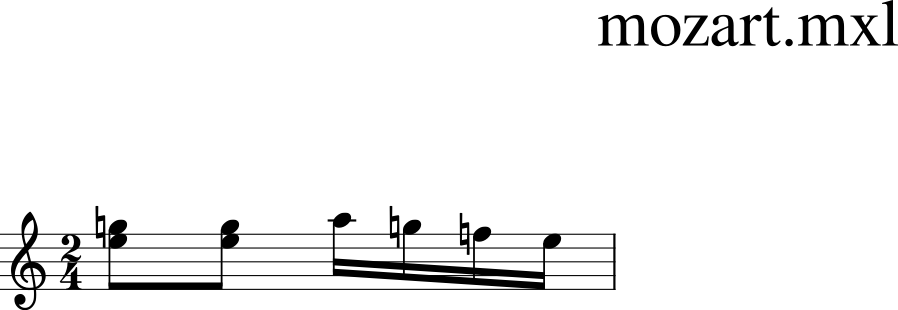

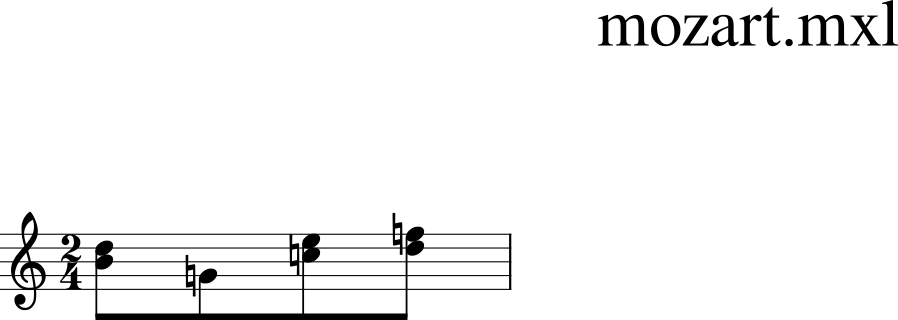

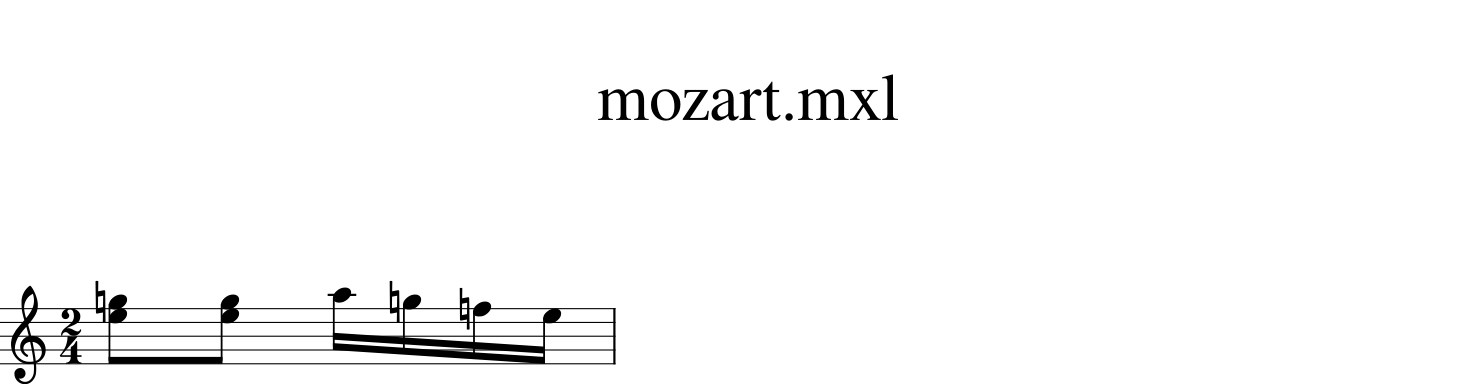

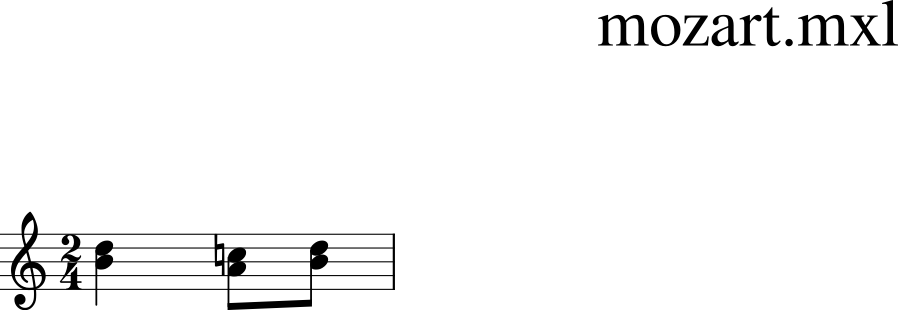

[[1.         0.16666667 1.         0.08333333]
 [0.16666667 1.         0.16666667 0.41666667]
 [1.         0.16666667 1.         0.08333333]
 [0.08333333 0.41666667 0.08333333 1.        ]]


In [18]:
measures_10_13 = c_measures[9:13]

for m in measures_10_13:
    m.show()

print(get_similarity_matrix(measures_10_13, get_pitch_similarity, [get_lev_distance_similarity]))

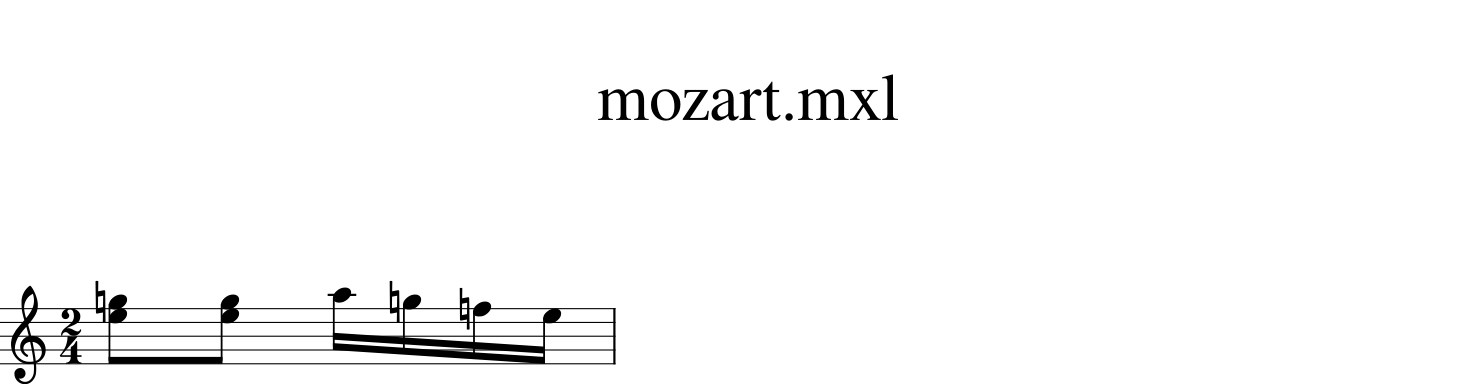

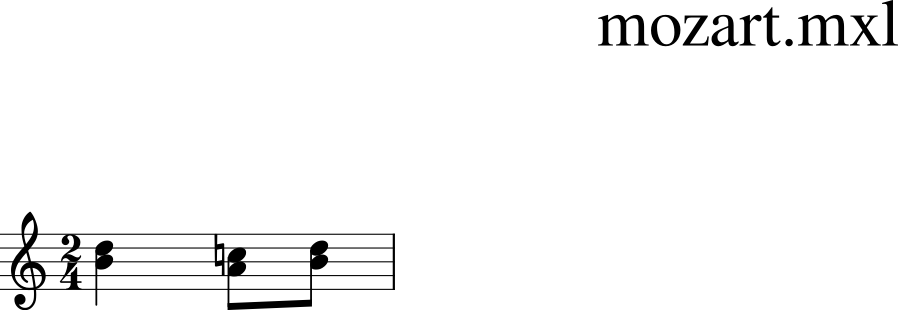

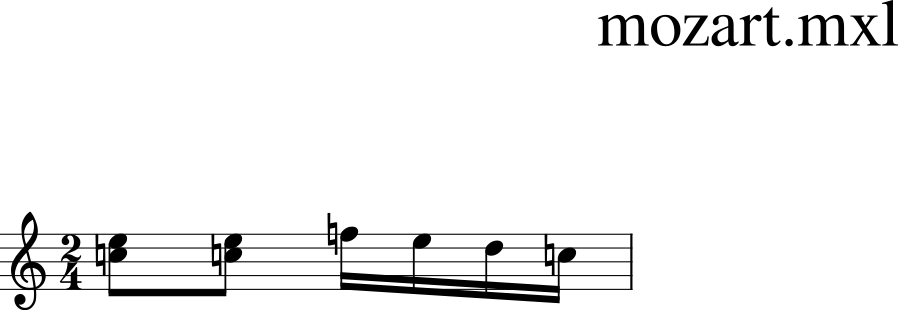

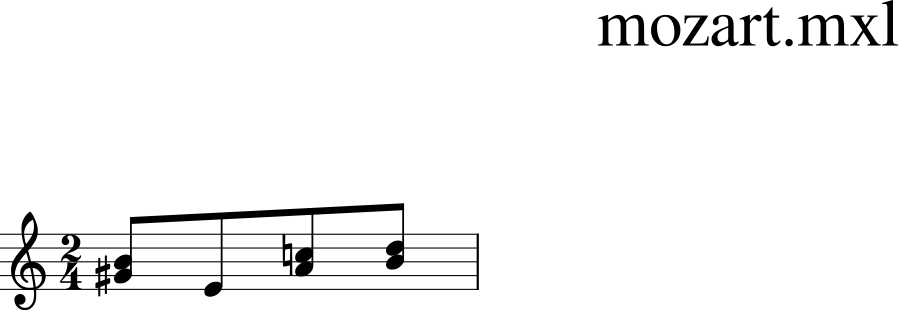

[[1.         0.08333333 0.11111111 0.16666667]
 [0.08333333 1.         0.13888889 0.58333333]
 [0.11111111 0.13888889 1.         0.16666667]
 [0.16666667 0.58333333 0.16666667 1.        ]]


In [19]:
measures_12_15 = c_measures[11:15]

for m in measures_12_15:
    m.show()

print(get_similarity_matrix(measures_12_15, get_pitch_similarity, [get_lev_distance_similarity]))

In [20]:
lst1 = [frozenset({4, 7}), frozenset({4, 7}), frozenset({9}), frozenset({7}), frozenset({5}), frozenset({4})]
lst2 = [frozenset({0, 4}), frozenset({0, 4}), frozenset({5}), frozenset({4}), frozenset({2}), frozenset({0})]

get_pitch_similarity(lst1, lst2, [get_lev_distance_similarity])


0.11111111111111105

In [21]:
rondo_alla_turca_pitch_similarity = get_both_parts_similarity_matrix(
    c, get_pitch_similarity, [get_lev_distance_similarity])

rondo_alla_turca_ledger_similarity = get_both_parts_similarity_matrix(
    c, get_ledger_similarity, [get_lev_distance_similarity])

rondo_alla_turca_transpose_similarity = get_both_parts_similarity_matrix(
    c, get_transpose_similarity, [get_lev_distance_similarity])

In [22]:
rondo_alla_turca_pitch_full_similarity = get_both_parts_similarity_matrix(
    c, get_pitch_similarity, [get_lev_distance_similarity, get_lcs_similarity])

rondo_alla_turca_ledger_full_similarity = get_both_parts_similarity_matrix(
    c, get_ledger_similarity, [get_lev_distance_similarity, get_lcs_similarity])

rondo_alla_turca_transpose_full_similarity = get_both_parts_similarity_matrix(
    c, get_transpose_similarity, [get_lev_distance_similarity, get_lcs_similarity])

# Make a heatmap!

In [23]:
rondo_alla_turca_ledger_similarity[24][28]

0.4625

In [24]:
rondo_alla_turca_ledger_similarity[1]

array([0.68      , 1.        , 0.83      , 0.64375   , 0.49      ,
       0.415     , 0.415     , 0.4275    , 0.3775    , 0.57083333,
       0.3775    , 0.57083333, 0.2925    , 0.57083333, 0.3775    ,
       0.57083333, 0.7175    , 1.        , 0.83      , 0.64375   ,
       0.585     , 0.56      , 0.39      , 0.79583333, 0.3775    ,
       0.56625   , 0.56625   , 0.380625  , 0.39625   , 0.56625   ,
       0.56625   , 0.38375   , 0.5475    , 0.68125   , 0.5       ,
       0.46875   , 0.39375   , 0.68125   , 0.5375    , 0.4625    ,
       0.5475    , 0.575     , 0.38125   , 0.575     , 0.5       ,
       0.575     , 0.38125   , 0.375     , 0.5475    , 0.68125   ,
       0.5       , 0.46875   , 0.39375   , 0.575     , 0.5375    ,
       0.35625   , 0.3775    , 0.56625   , 0.56625   , 0.380625  ,
       0.39625   , 0.56625   , 0.56625   , 0.38375   , 0.8875    ,
       1.        , 0.83      , 0.64375   , 0.49      , 0.415     ,
       0.415     , 0.4275    , 0.3775    , 0.57083333, 0.3775 

In [25]:
rondo_alla_turca_pitch_similarity[1]

array([0.        , 1.        , 0.15      , 0.21875   , 0.49      ,
       0.0375    , 0.0375    , 0.0125    , 0.10375   , 0.05625   ,
       0.085     , 0.05625   , 0.255     , 0.2875    , 0.18875   ,
       0.57083333, 0.01875   , 1.        , 0.15      , 0.21875   ,
       0.34      , 0.1825    , 0.0125    , 0.48125   , 0.2075    ,
       0.1825    , 0.0125    , 0.1825    , 0.22625   , 0.1825    ,
       0.0125    , 0.040625  , 0.2075    , 0.        , 0.        ,
       0.        , 0.2125    , 0.        , 0.0375    , 0.2125    ,
       0.1825    , 0.18125   , 0.13125   , 0.18125   , 0.14166667,
       0.18125   , 0.13125   , 0.1625    , 0.2075    , 0.        ,
       0.        , 0.        , 0.31875   , 0.10625   , 0.14375   ,
       0.        , 0.2075    , 0.1825    , 0.0125    , 0.1825    ,
       0.22625   , 0.1825    , 0.0125    , 0.040625  , 0.0375    ,
       1.        , 0.15      , 0.21875   , 0.49      , 0.0375    ,
       0.0375    , 0.0125    , 0.10375   , 0.05625   , 0.085  

In [26]:
# How about EXACT transposition?
rondo_alla_turca_transpose_similarity[1]

array([0.68      , 1.        , 0.83      , 0.64375   , 0.49      ,
       0.415     , 0.415     , 0.4275    , 0.2925    , 0.41041667,
       0.3775    , 0.41041667, 0.2925    , 0.35833333, 0.2925    ,
       0.57083333, 0.7175    , 1.        , 0.83      , 0.64375   ,
       0.3775    , 0.56      , 0.3775    , 0.5125    , 0.3775    ,
       0.39625   , 0.56625   , 0.368125  , 0.22625   , 0.39625   ,
       0.56625   , 0.38375   , 0.3775    , 0.68125   , 0.39375   ,
       0.46875   , 0.5       , 0.68125   , 0.56875   , 0.39375   ,
       0.52875   , 0.5       , 0.38125   , 0.5       , 0.4625    ,
       0.5       , 0.38125   , 0.375     , 0.3775    , 0.68125   ,
       0.39375   , 0.46875   , 0.5       , 0.575     , 0.4625    ,
       0.39375   , 0.2075    , 0.39625   , 0.56625   , 0.368125  ,
       0.22625   , 0.39625   , 0.56625   , 0.38375   , 0.8875    ,
       1.        , 0.83      , 0.64375   , 0.49      , 0.415     ,
       0.415     , 0.4275    , 0.2925    , 0.41041667, 0.3775 

In [27]:
import seaborn as sns

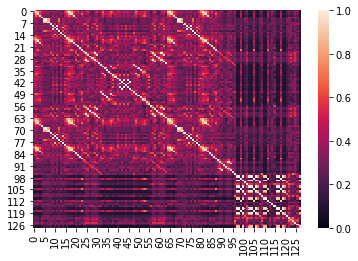

In [28]:
ax = sns.heatmap(rondo_alla_turca_transpose_similarity, vmin=0, vmax=1)

In [29]:
[rondo_alla_turca_transpose_similarity[a][b] for a, b in zip(range(20, 30), range(84, 94))]

[1.0, 1.0, 1.0, 1.0, 0.66, 0.575, 0.575, 0.575, 0.575, 0.575]

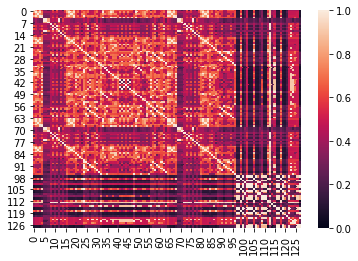

In [30]:
ax = sns.heatmap(rondo_alla_turca_transpose_full_similarity, vmin=0, vmax=1)

In [31]:
[rondo_alla_turca_transpose_full_similarity[a][b] for a, b in zip(range(20, 30), range(84, 94))]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

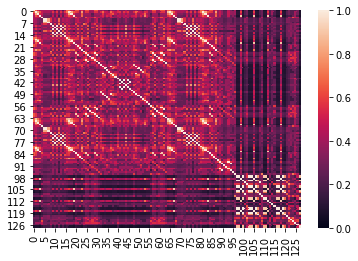

In [32]:
ax = sns.heatmap(rondo_alla_turca_ledger_similarity, vmin=0, vmax=1)

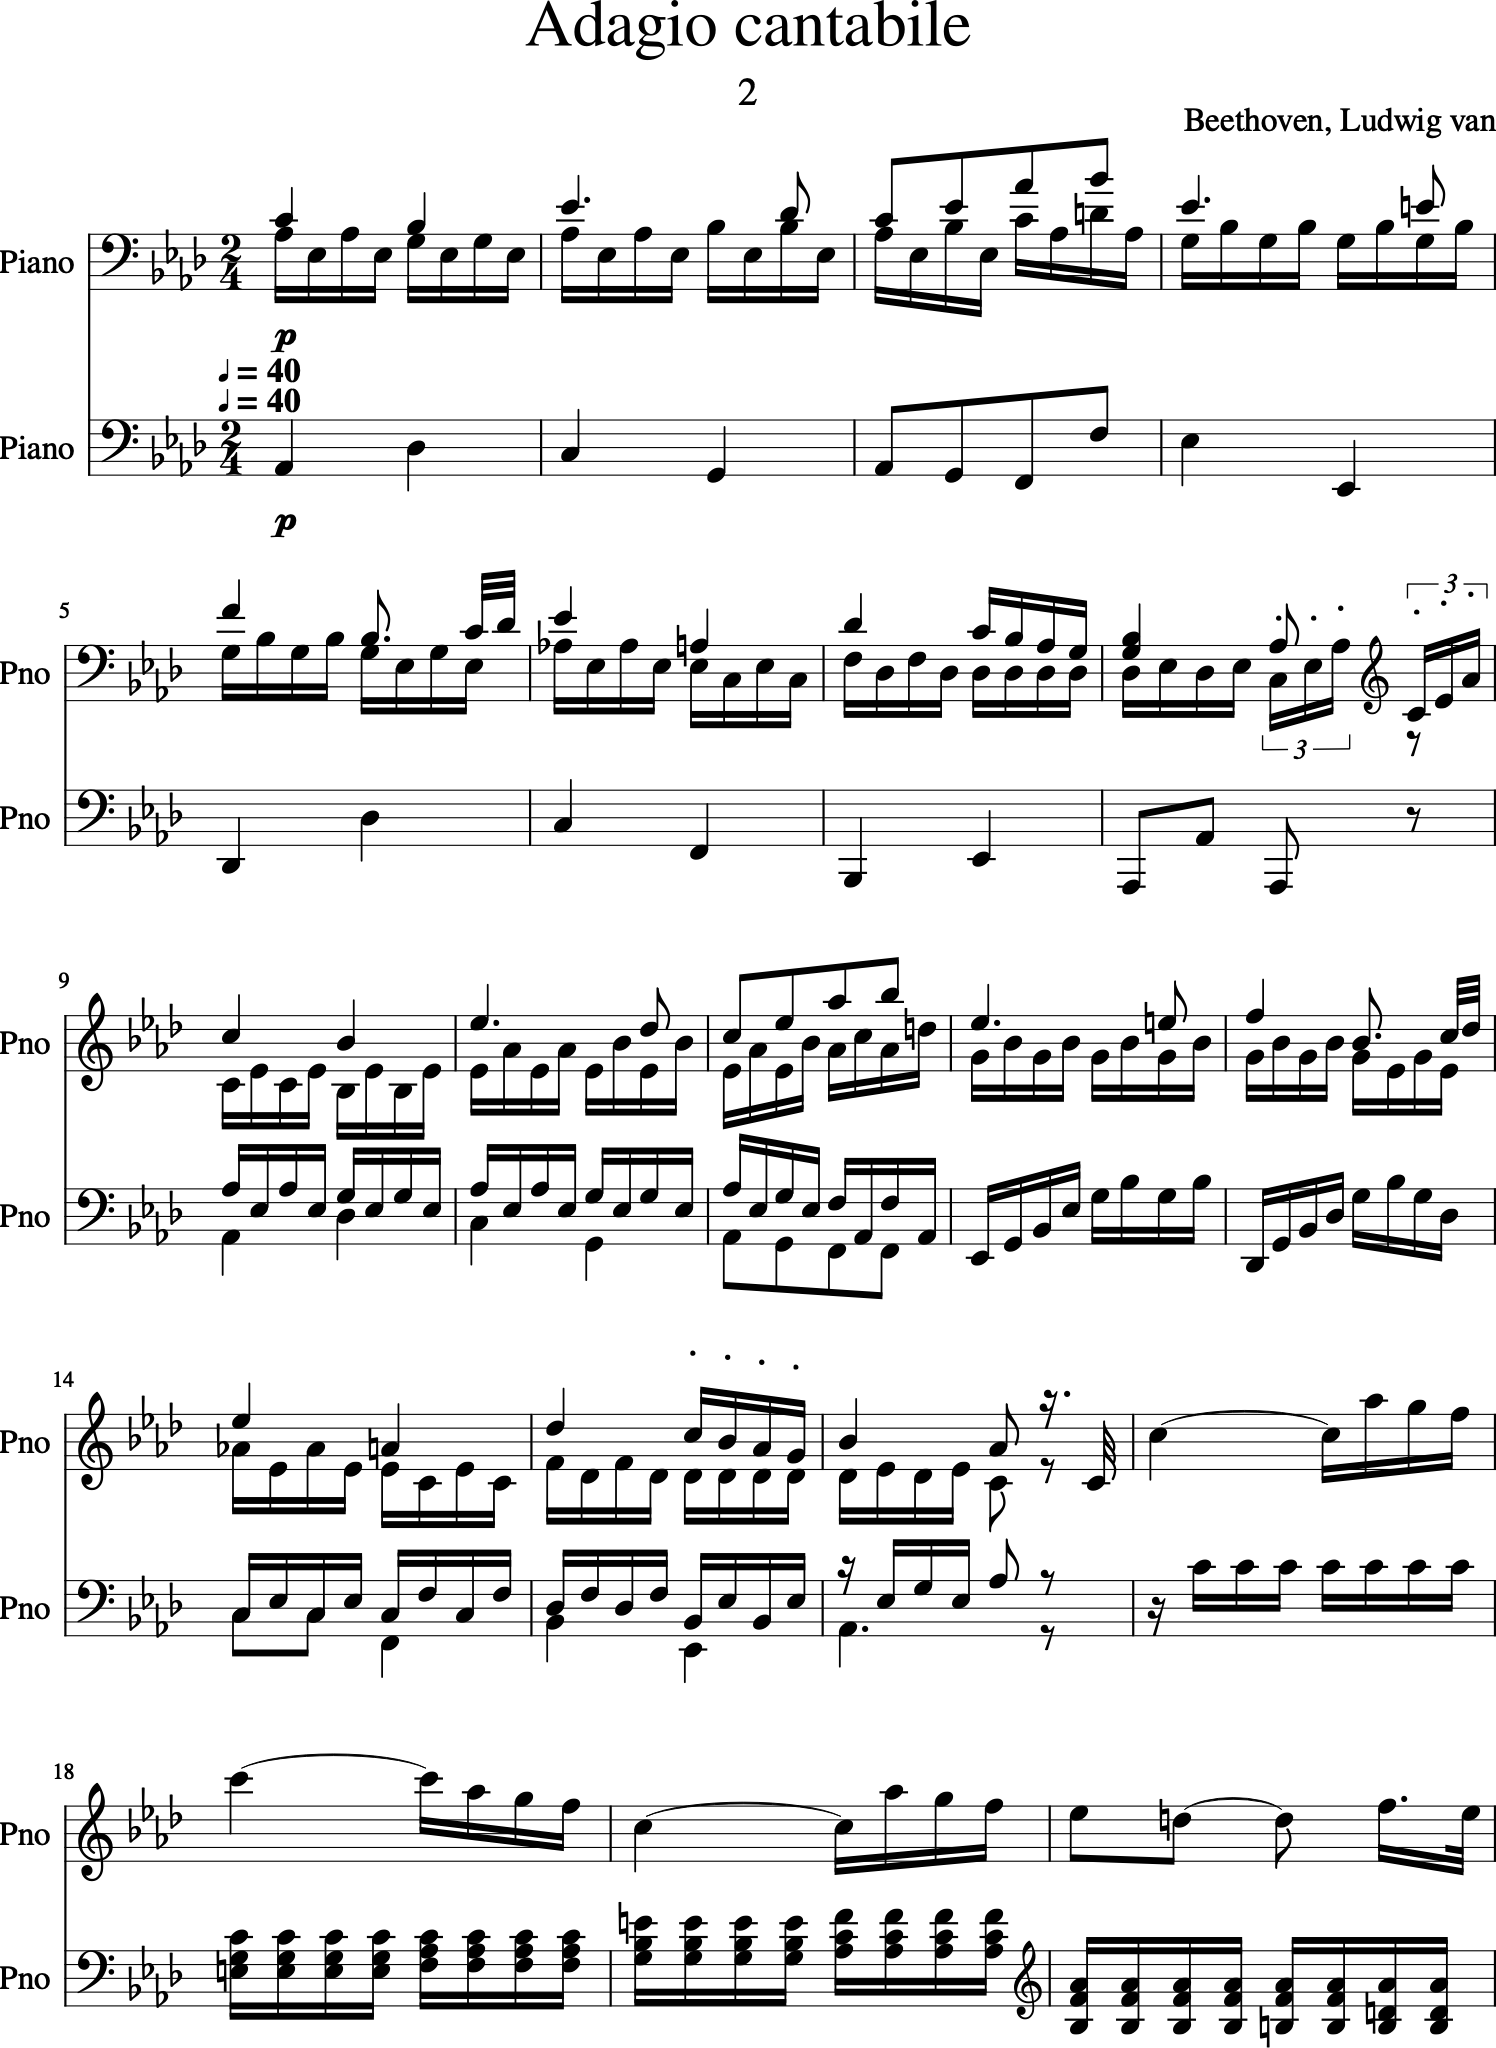

In [33]:
pathetique2 = converter.parse('https://kern.humdrum.org/cgi-bin/ksdata?l=users/craig/classical/beethoven/piano/sonata&file=sonata08-2.krn&f=kern')

pathetique2.show()

pathetique2_measures = list(pathetique2.parts[0].getElementsByClass(stream.Measure))

In [34]:
pathetique2_transpose_full_similarity = get_similarity_matrix(
    pathetique2_measures, get_transpose_similarity, [get_lev_distance_similarity, get_lcs_similarity])

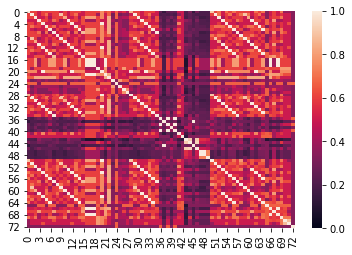

In [35]:
ax = sns.heatmap(pathetique2_transpose_full_similarity, vmin=0, vmax=1)

In [36]:
indices = np.where(pathetique2_transpose_full_similarity > 0.9)
indices

(array([ 0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8,  9,
         9, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 14, 14, 14, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17,
        17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 20, 20, 20, 20, 20, 20, 20,
        20, 21, 21, 21, 21, 22, 23, 24, 25, 26, 27, 28, 28, 29, 29, 29, 30,
        30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33,
        33, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 38, 38, 38,
        39, 40, 40, 40, 41, 42, 43, 43, 43, 44, 44, 44, 45, 45, 46, 46, 46,
        47, 47, 48, 48, 49, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 53,
        53, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56,
        57, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 61, 61, 61, 62, 62, 62,
        62, 62, 62, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 66, 66, 66,
        66, 

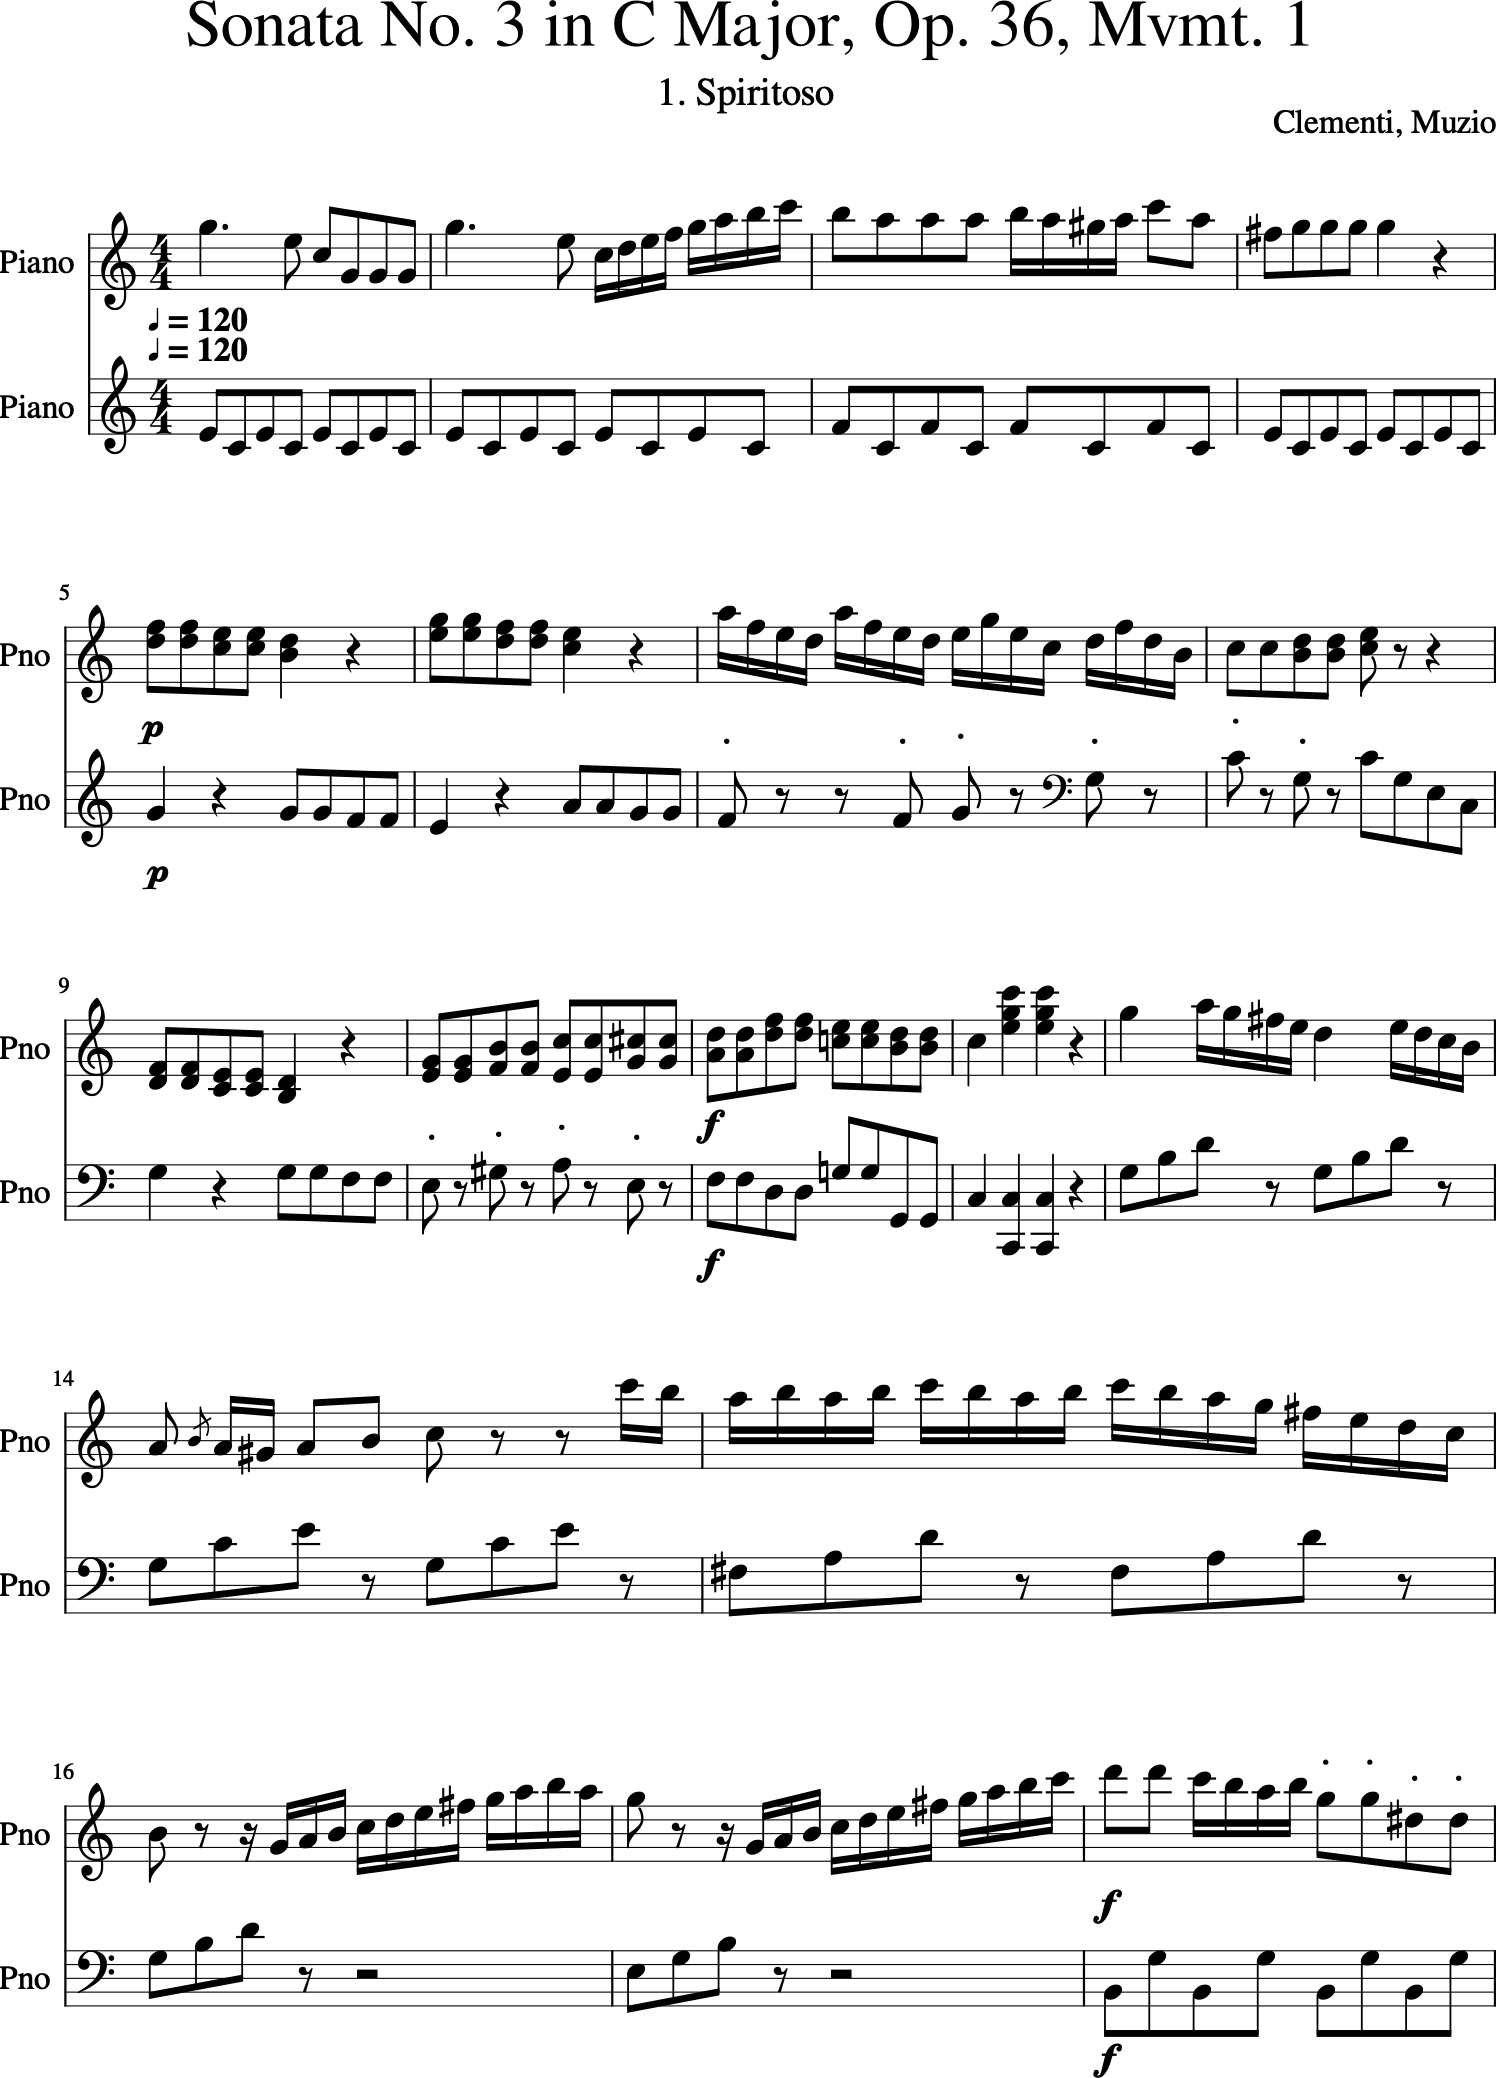

In [37]:
op36no3 = converter.parse('https://kern.humdrum.org/cgi-bin/ksdata?l=users/craig/classical/clementi/op36&file=sonatina-36-3-1.krn&f=kern')
op36no3.show()

In [38]:
op36no3_transpose_full_similarity = get_both_parts_similarity_matrix(
    op36no3, get_transpose_similarity, [get_lev_distance_similarity, get_lcs_similarity])

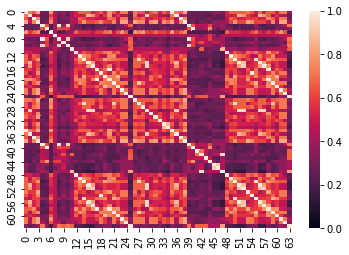

In [39]:
ax = sns.heatmap(op36no3_transpose_full_similarity, vmin=0, vmax=1)

Here, we test a Mozart sonata.

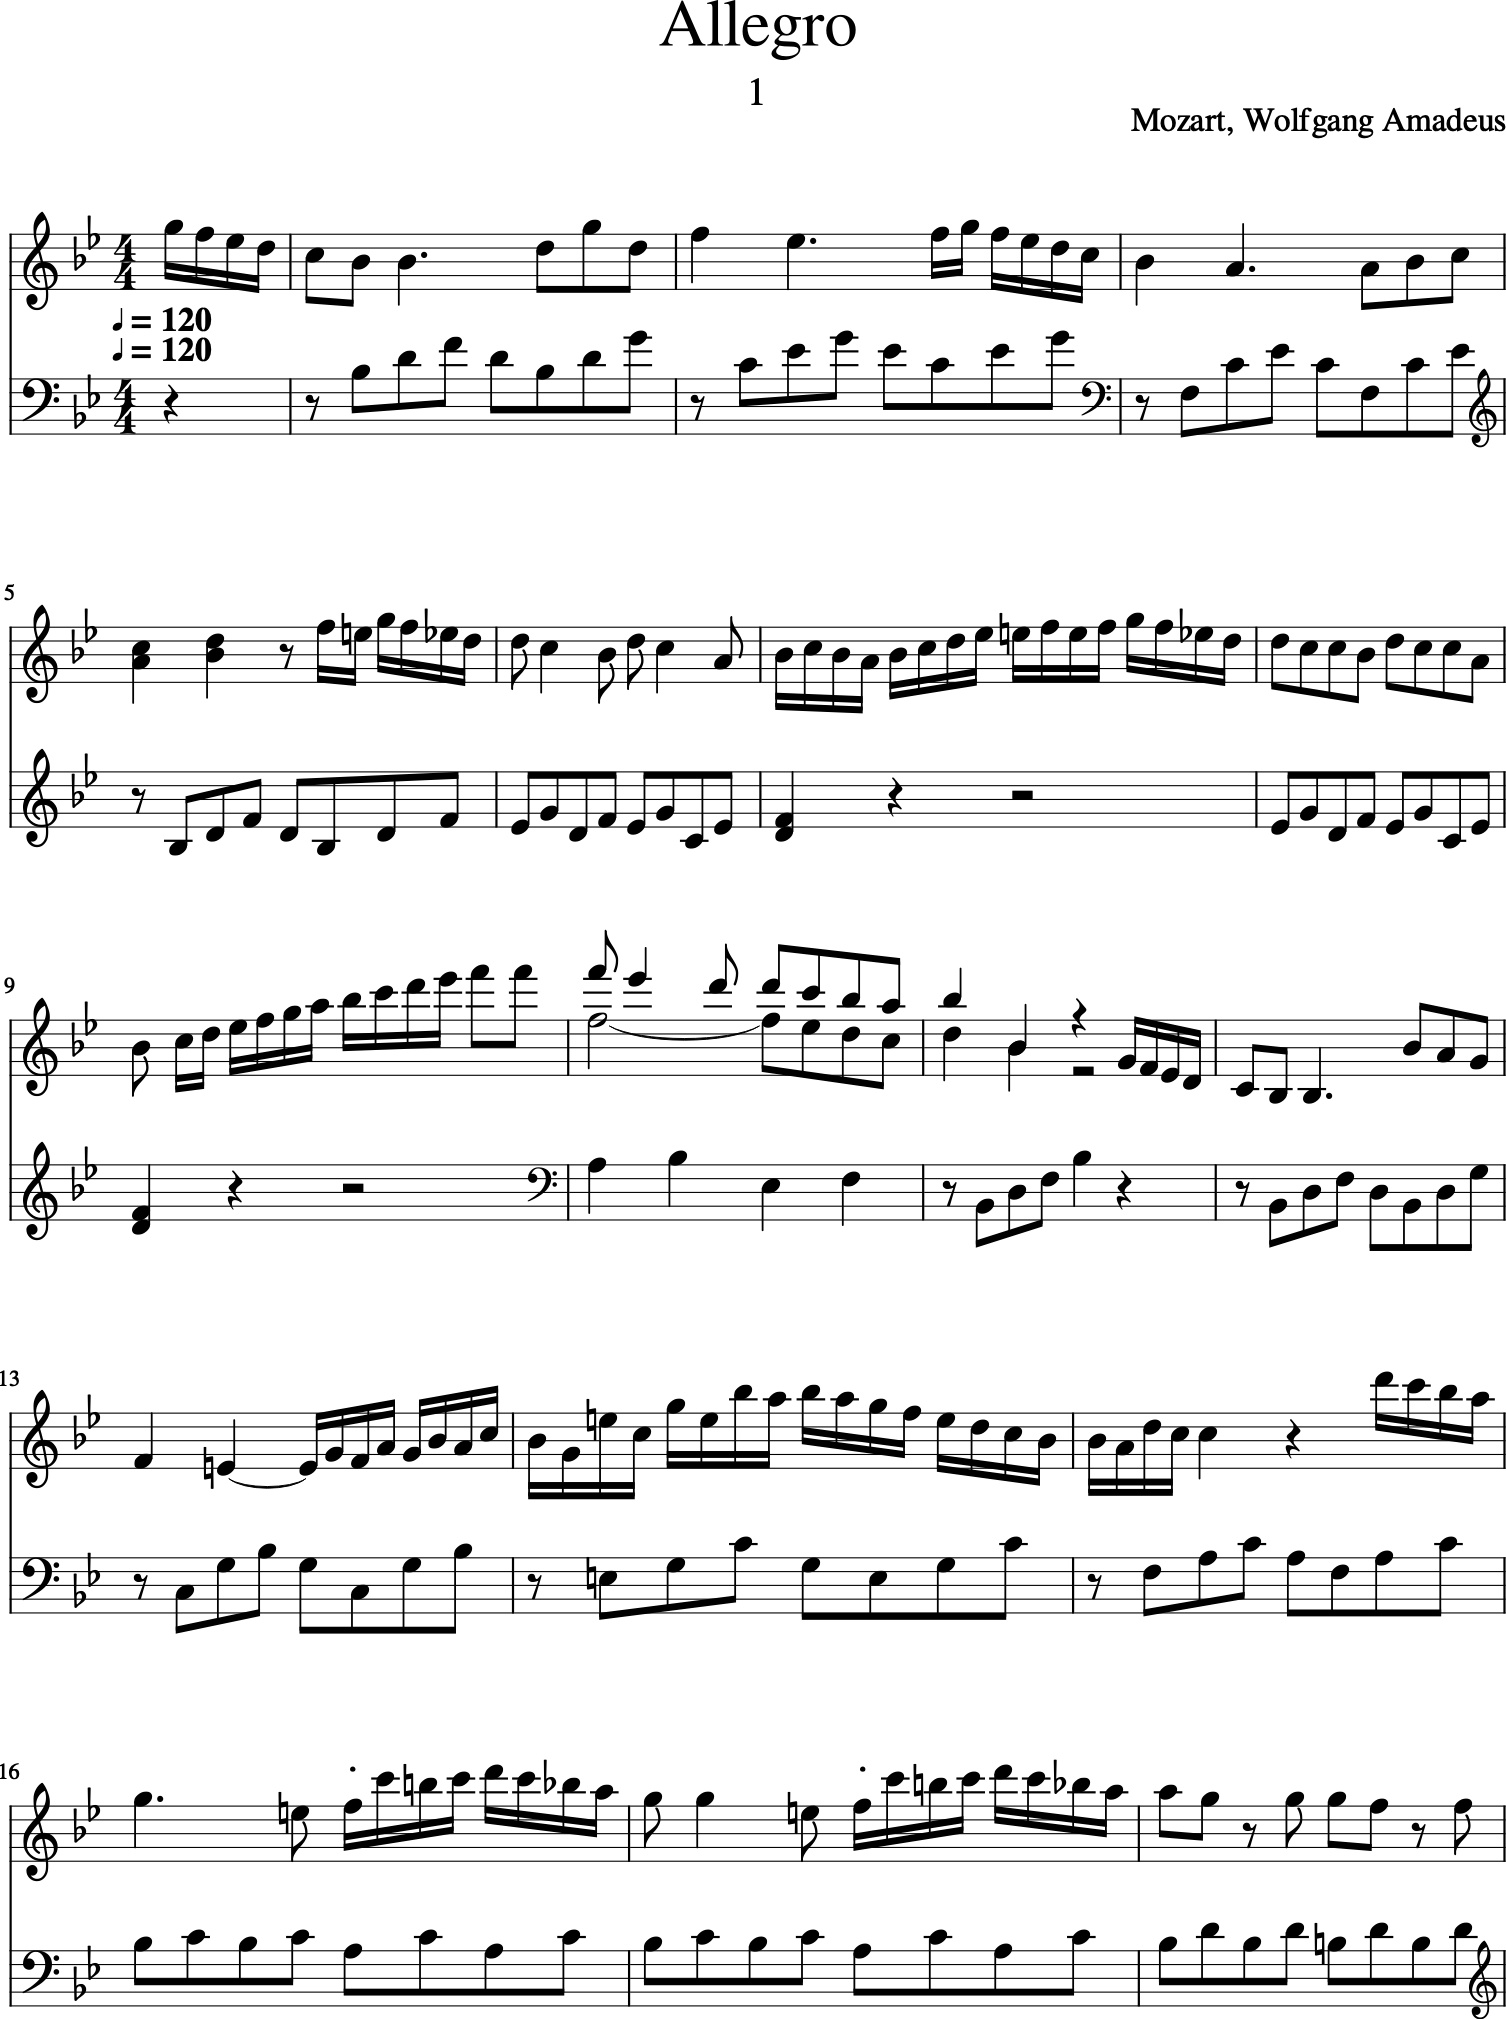

In [40]:
mozart13 = converter.parse('https://kern.humdrum.org/cgi-bin/ksdata?location=users/craig/classical/mozart/piano/sonata&file=sonata13-1.krn&format=kern')
mozart13.show()

In [41]:
mozart13_pitch_similarity = get_both_parts_similarity_matrix(
    mozart13, get_pitch_similarity, [get_lev_distance_similarity])

mozart13_ledger_similarity = get_both_parts_similarity_matrix(
    mozart13, get_ledger_similarity, [get_lev_distance_similarity])

mozart13_transpose_similarity = get_both_parts_similarity_matrix(
    mozart13, get_transpose_similarity, [get_lev_distance_similarity])

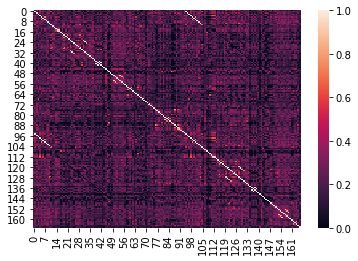

In [42]:
ax = sns.heatmap(mozart13_pitch_similarity, vmin=0, vmax=1)

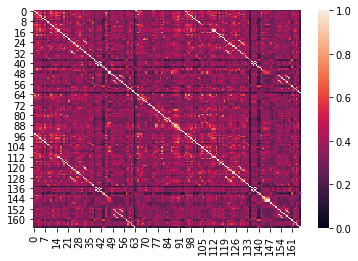

In [43]:
ax = sns.heatmap(mozart13_ledger_similarity, vmin=0, vmax=1)

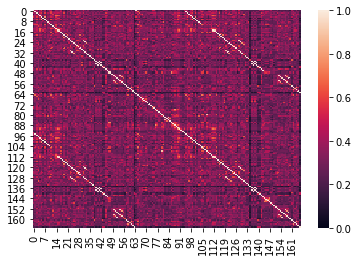

In [44]:
ax = sns.heatmap(mozart13_transpose_similarity, vmin=0, vmax=1)

Now let's test a minor-key sonata.

In [45]:
mozart8 = converter.parse('https://kern.humdrum.org/cgi-bin/ksdata?location=users/craig/classical/mozart/piano/sonata&file=sonata08-1.krn&format=kern')

In [46]:
mozart8_pitch_similarity = get_both_parts_similarity_matrix(
    mozart8, get_pitch_similarity, [get_lev_distance_similarity])

mozart8_ledger_similarity = get_both_parts_similarity_matrix(
    mozart8, get_ledger_similarity, [get_lev_distance_similarity])

mozart8_transpose_similarity = get_both_parts_similarity_matrix(
    mozart8, get_transpose_similarity, [get_lev_distance_similarity])

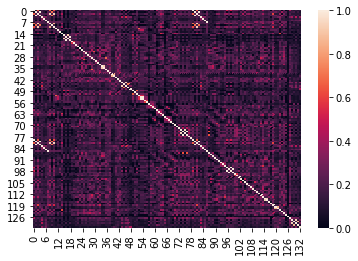

In [47]:
ax = sns.heatmap(mozart8_pitch_similarity, vmin=0, vmax=1)

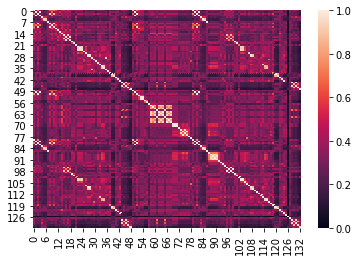

In [48]:
ax = sns.heatmap(mozart8_ledger_similarity, vmin=0, vmax=1)

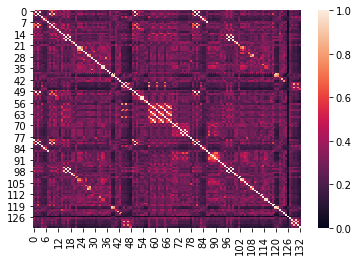

In [49]:
ax = sns.heatmap(mozart8_transpose_similarity, vmin=0, vmax=1)

In [66]:
diff_sim = np.abs(mozart8_ledger_similarity - mozart8_transpose_similarity)

max_diff_indices = np.unravel_index(np.argsort(-diff_sim, axis=None), diff_sim.shape)
num_max = 10

(max_diff_indices[0][:num_max], max_diff_indices[1][:num_max])

(array([130,  46,  44, 128,  46, 128,  44, 130,  57,  46]),
 array([ 46, 130, 128,  44, 128,  46, 130,  44,  46,  57]))

In [56]:
facile = converter.parse('https://kern.humdrum.org/cgi-bin/ksdata?location=users/craig/classical/mozart/piano/sonata&file=sonata15-1.krn&format=kern')

In [51]:
facile_pitch_similarity = get_both_parts_similarity_matrix(
    facile, get_pitch_similarity, [get_lev_distance_similarity])

facile_ledger_similarity = get_both_parts_similarity_matrix(
    facile, get_ledger_similarity, [get_lev_distance_similarity])

facile_transpose_similarity = get_both_parts_similarity_matrix(
    facile, get_transpose_similarity, [get_lev_distance_similarity])

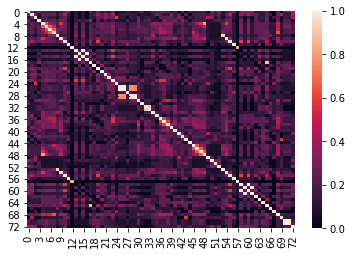

In [52]:
ax = sns.heatmap(facile_pitch_similarity, vmin=0, vmax=1)

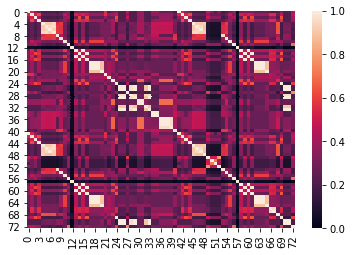

In [53]:
ax = sns.heatmap(facile_ledger_similarity, vmin=0, vmax=1)

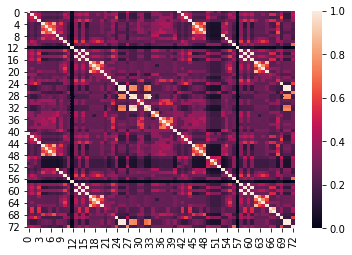

In [54]:
ax = sns.heatmap(facile_transpose_similarity, vmin=0, vmax=1)

In [58]:
beethoven1 = converter.parse('https://kern.humdrum.org/cgi-bin/ksdata?l=users/craig/classical/beethoven/piano/sonata&file=sonata01-1.krn&f=kern')

In [59]:
beethoven1_pitch_similarity = get_both_parts_similarity_matrix(
    beethoven1, get_pitch_similarity, [get_lev_distance_similarity])

beethoven1_ledger_similarity = get_both_parts_similarity_matrix(
    beethoven1, get_ledger_similarity, [get_lev_distance_similarity])

beethoven1_transpose_similarity = get_both_parts_similarity_matrix(
    beethoven1, get_transpose_similarity, [get_lev_distance_similarity])

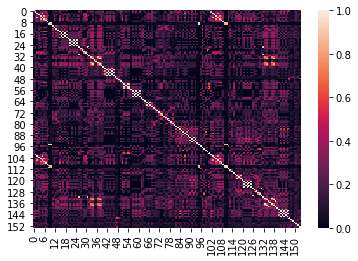

In [60]:
ax = sns.heatmap(beethoven1_pitch_similarity, vmin=0, vmax=1)

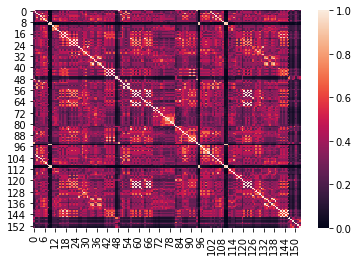

In [61]:
ax = sns.heatmap(beethoven1_ledger_similarity, vmin=0, vmax=1)

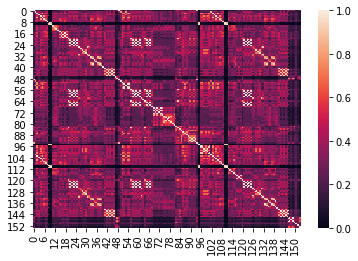

In [62]:
ax = sns.heatmap(beethoven1_transpose_similarity, vmin=0, vmax=1)